# acknowledgement
- [Med Ali Bouchhioua](https://www.kaggle.com/medali1992)

In [1]:
import pandas as pd
import numpy as np
import wandb
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte
from typing import Tuple

# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict


import scipy as sp

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


from torch.cuda.amp import autocast, GradScaler

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Train data
train = pd.read_csv('../input/signature-verification-dataset/sign_data/train_data.csv')
train.rename(columns={"1":"label"}, inplace=True)
train["image_real_paths"] = train["068/09_068.png"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/train/{x}")
train["image_forged_paths"] = train["068_forg/03_0113068.PNG"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/train/{x}")

# Test data
test = pd.read_csv('../input/signature-verification-dataset/sign_data/test_data.csv')
test.rename(columns={"1":"label"}, inplace=True)
test["image_real_paths"] = test["068/09_068.png"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/test/{x}")
test["image_forged_paths"] = test["068_forg/03_0113068.PNG"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/test/{x}")

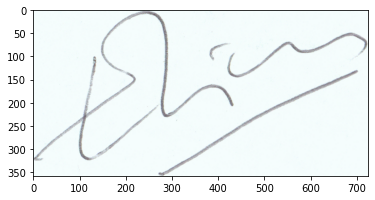

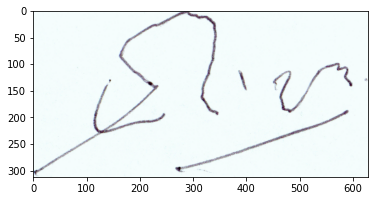

In [3]:
from skimage import io
img1 = io.imread('../input/signature-verification-dataset/sign_data/train/001/001_01.PNG')
plt.imshow(img1)
plt.show()
img2 = io.imread('../input/signature-verification-dataset/sign_data/train/001_forg/0119001_01.png')
plt.imshow(img2)
plt.show()

In [4]:
train.shape

(23205, 5)

In [5]:
test.shape

(5747, 5)

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [7]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=128
    num_workers=2
    scheduler='OneCycleLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=15
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':3,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3,
        'steps_per_epoch':7, 
        'epochs':7
    }
    batch_size=8
    lr=1e-2
    weight_decay=1e-3
    canvas_size = (952, 1360)
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_size=train["label"].shape[0]
    nfolds=5
    trn_folds=[0]
    model_name='convnet'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'tresnet_m'
    train=True
    early_stop=True
    target_col="label"
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    
if CFG.debug:
    CFG.epochs=1
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [8]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key")

import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Signature", 
                 name="convnet",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mohamedamine. Use `wandb login --relogin` to force relogin


In [9]:
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [10]:
def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    """ Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.
    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------
    """
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    """ Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size
    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """
    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)
    
    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]
    
    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def remove_background(img: np.ndarray) -> np.ndarray:
        """ Remove noise using OTSU's method.
        Parameters
        ----------
        img : np.ndarray
            The image to be processed
        Returns
        -------
        np.ndarray
            The image with background removed
        """

        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    """ Crops an image to the desired size without stretching it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size
    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image
        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of multiple images
        Parameters
        ----------
        imgs : np.ndarray (N x C x H_old x W_old)
            The images to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray (N x C x H x W)
            The cropped images
        """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')

    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    #plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [11]:
canvas_size = (952, 1360)
img_size = (256, 256)
input_size = (256, 256)

observation = train.iloc[10]
img1 = load_signature(observation["image_real_paths"])
img2 = load_signature(observation["image_forged_paths"])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

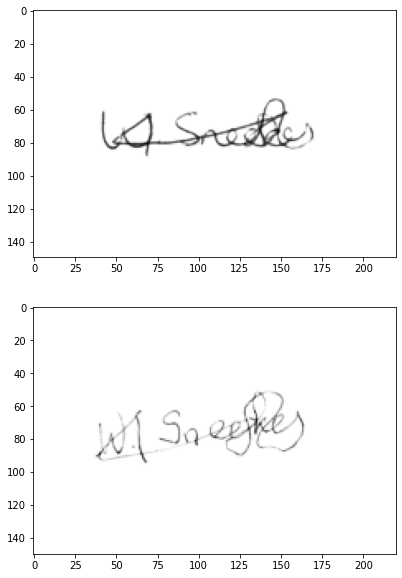

In [12]:
# Shows pre-processed samples of the two users

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(preprocessed_img1)
ax[1].imshow(preprocessed_img2)

In [13]:
class SignatureDataset(Dataset):
    
    def __init__(self, df=train, canvas_size=canvas_size, dim=(256, 256)):
        self.df  = df
        self.real_file_names = df["image_real_paths"].values
        self.forged_file_names = df["image_forged_paths"].values
        self.labels = df["label"].values
        self.dim = dim

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,index):
        # getting the image path
        real_file_path = self.real_file_names[index]
        forged_file_path = self.forged_file_names[index]
        
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)
        
        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)
        
        label = torch.tensor(self.labels[index], dtype=torch.long)
        
        return torch.tensor(img1), torch.tensor(img2), label

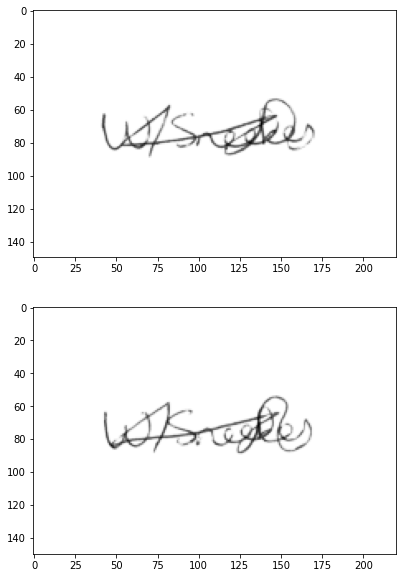

In [14]:
train_dataset = SignatureDataset(train, canvas_size, img_size)
img1, img2, _ = train_dataset[120]

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(img1)
ax[1].imshow(img2)

In [15]:
class SigNet(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SigNet, self).__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_mish(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_mish(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_mish(256, 384, 3, pad=1)),
            ('conv4', conv_bn_mish(384, 384, 3, pad=1)),
            ('conv5', conv_bn_mish(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_mish(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_mish(self.feature_space_size, self.feature_space_size)),
        ]))
    
    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        # forward pass of input 1
        output1 = self.forward_once(img1)
        # forward pass of input 2
        output2 = self.forward_once(img2)
        return output1, output2


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('relu', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('relu', nn.Mish()),
    ]))

In [16]:
#model = SigNet()
#model.eval()
#x1, x2 = model(img1, img2)

In [17]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.cosine_similarity(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, layer):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    tk0 = tqdm(train_loader, total=len(train_loader))
    for step, (img1, img2, labels) in enumerate(tk0):
        # measure data loading time
        data_time.update(time.time() - end)
        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                out1, out2 = model(img1, img2)
                layer1 = layer(out1)
                layer2 = layer(out2)
                loss = criterion(layer1, layer2, labels)
        else:
            out1, out2 = model(img1, img2)
            loss = criterion(out1, out2, labels)
            
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_last_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_last_lr()[0]})
    return losses.avg

In [19]:
# ====================================================
# Train loop
# ====================================================
def train_loop():
    

    # ====================================================
    # loader
    # ====================================================
    
    train_dataset = SignatureDataset(train, CFG.canvas_size, dim=(256, 256))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
   
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='OneCycleLR':
            scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = SigNet()
    state_dict, _, _ = torch.load("../input/pretrained-signature-weights/signet.pth")
    model.load_state_dict(state_dict)
    model.to(device)
    

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterions = ContrastiveLoss()
    contrastive_layer = nn.Linear(2048, 2)
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train, train_loader, model, criterions, optimizer, epoch, scheduler, device, contrastive_layer)

        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, OneCycleLR):
            scheduler.step()


        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
        wandb.log({f"epoch": epoch+1, 
                   f"avg_train_loss": avg_loss})
                 
            
        if avg_loss < best_loss:
            best_loss = avg_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict()}, 
                        OUTPUT_DIR+f'{CFG.model_name}_best_loss.pt')
   
   
    wandb.finish()    
    return model

In [20]:
model = train_loop()

  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [1][0/2900] Elapsed 0m 11s (remain 554m 16s) Loss: 0.3113(0.3113) Grad: 3.6584 LR: 0.000010  
Epoch: [1][100/2900] Elapsed 1m 24s (remain 39m 9s) Loss: 0.2866(0.3533) Grad: 3.6226 LR: 0.000010  
Epoch: [1][200/2900] Elapsed 2m 21s (remain 31m 43s) Loss: 0.2169(0.3311) Grad: 3.6442 LR: 0.000010  
Epoch: [1][300/2900] Elapsed 3m 18s (remain 28m 29s) Loss: 0.2464(0.3166) Grad: 3.7028 LR: 0.000010  
Epoch: [1][400/2900] Elapsed 4m 14s (remain 26m 26s) Loss: 0.2465(0.3058) Grad: 3.4538 LR: 0.000010  
Epoch: [1][500/2900] Elapsed 5m 10s (remain 24m 47s) Loss: 0.2119(0.2973) Grad: 4.3512 LR: 0.000010  
Epoch: [1][600/2900] Elapsed 6m 7s (remain 23m 25s) Loss: 0.2527(0.2890) Grad: 5.1821 LR: 0.000010  
Epoch: [1][700/2900] Elapsed 7m 2s (remain 22m 6s) Loss: 0.2744(0.2818) Grad: 5.2093 LR: 0.000010  
Epoch: [1][800/2900] Elapsed 7m 59s (remain 20m 55s) Loss: 0.2359(0.2754) Grad: 4.3421 LR: 0.000010  
Epoch: [1][900/2900] Elapsed 8m 54s (remain 19m 45s) Loss: 0.2544(0.2695) Grad: 5.2422 

Epoch 1 - avg_train_loss: 0.1973  time: 1650s
Epoch 1 - Save Best Loss: 0.1973 Model


Epoch: [1][2899/2900] Elapsed 27m 30s (remain 0m 0s) Loss: 0.1012(0.1973) Grad: 4.3811 LR: 0.000010  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [2][0/2900] Elapsed 0m 2s (remain 144m 11s) Loss: 0.1125(0.1125) Grad: 3.0279 LR: 0.000162  
Epoch: [2][100/2900] Elapsed 1m 2s (remain 28m 48s) Loss: 0.3301(0.2572) Grad: 3.2575 LR: 0.000162  
Epoch: [2][200/2900] Elapsed 1m 59s (remain 26m 51s) Loss: 0.2392(0.2629) Grad: 2.9197 LR: 0.000162  
Epoch: [2][300/2900] Elapsed 2m 56s (remain 25m 22s) Loss: 0.2498(0.2569) Grad: 2.8573 LR: 0.000162  
Epoch: [2][400/2900] Elapsed 3m 52s (remain 24m 11s) Loss: 0.1224(0.2540) Grad: 2.3224 LR: 0.000162  
Epoch: [2][500/2900] Elapsed 4m 50s (remain 23m 11s) Loss: 0.1989(0.2473) Grad: 2.0925 LR: 0.000162  
Epoch: [2][600/2900] Elapsed 5m 48s (remain 22m 12s) Loss: 0.0502(0.2363) Grad: 1.0183 LR: 0.000162  
Epoch: [2][700/2900] Elapsed 6m 45s (remain 21m 10s) Loss: 0.1424(0.2281) Grad: 2.8993 LR: 0.000162  
Epoch: [2][800/2900] Elapsed 7m 43s (remain 20m 14s) Loss: 0.0744(0.2219) Grad: 3.0996 LR: 0.000162  
Epoch: [2][900/2900] Elapsed 8m 41s (remain 19m 17s) Loss: 0.2579(0.2152) Grad: 3.118

Epoch 2 - avg_train_loss: 0.1592  time: 1646s
Epoch 2 - Save Best Loss: 0.1592 Model


Epoch: [2][2899/2900] Elapsed 27m 25s (remain 0m 0s) Loss: 0.0291(0.1592) Grad: 0.7826 LR: 0.000162  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [3][0/2900] Elapsed 0m 2s (remain 137m 19s) Loss: 0.0182(0.0182) Grad: 0.3815 LR: 0.000525  
Epoch: [3][100/2900] Elapsed 1m 0s (remain 27m 50s) Loss: 0.4549(0.2707) Grad: 3.0977 LR: 0.000525  
Epoch: [3][200/2900] Elapsed 1m 56s (remain 26m 1s) Loss: 0.2566(0.2905) Grad: 1.7555 LR: 0.000525  
Epoch: [3][300/2900] Elapsed 2m 51s (remain 24m 37s) Loss: 0.1465(0.2841) Grad: 2.0606 LR: 0.000525  
Epoch: [3][400/2900] Elapsed 3m 47s (remain 23m 37s) Loss: 0.6148(0.2775) Grad: 2.7553 LR: 0.000525  
Epoch: [3][500/2900] Elapsed 4m 43s (remain 22m 35s) Loss: 0.3522(0.2630) Grad: 2.3863 LR: 0.000525  
Epoch: [3][600/2900] Elapsed 5m 38s (remain 21m 35s) Loss: 0.1117(0.2483) Grad: 2.5031 LR: 0.000525  
Epoch: [3][700/2900] Elapsed 6m 33s (remain 20m 33s) Loss: 0.1218(0.2406) Grad: 3.2886 LR: 0.000525  
Epoch: [3][800/2900] Elapsed 7m 28s (remain 19m 34s) Loss: 0.1016(0.2310) Grad: 1.8477 LR: 0.000525  
Epoch: [3][900/2900] Elapsed 8m 24s (remain 18m 38s) Loss: 0.1322(0.2215) Grad: 1.7869

Epoch 3 - avg_train_loss: 0.1684  time: 1619s


Epoch: [3][2899/2900] Elapsed 26m 59s (remain 0m 0s) Loss: 0.1394(0.1684) Grad: 2.3972 LR: 0.000525  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [4][0/2900] Elapsed 0m 2s (remain 127m 20s) Loss: 0.1934(0.1934) Grad: 2.6543 LR: 0.000876  
Epoch: [4][100/2900] Elapsed 1m 1s (remain 28m 27s) Loss: 0.1877(0.1704) Grad: 1.7300 LR: 0.000876  
Epoch: [4][200/2900] Elapsed 1m 58s (remain 26m 26s) Loss: 0.0805(0.1676) Grad: 1.6621 LR: 0.000876  
Epoch: [4][300/2900] Elapsed 2m 53s (remain 25m 0s) Loss: 0.2410(0.1699) Grad: 2.8397 LR: 0.000876  
Epoch: [4][400/2900] Elapsed 3m 49s (remain 23m 51s) Loss: 0.1840(0.1691) Grad: 1.4860 LR: 0.000876  
Epoch: [4][500/2900] Elapsed 4m 45s (remain 22m 49s) Loss: 0.1553(0.1621) Grad: 1.9913 LR: 0.000876  
Epoch: [4][600/2900] Elapsed 5m 41s (remain 21m 47s) Loss: 0.1566(0.1567) Grad: 2.3338 LR: 0.000876  
Epoch: [4][700/2900] Elapsed 6m 37s (remain 20m 46s) Loss: 0.2340(0.1590) Grad: 3.5498 LR: 0.000876  
Epoch: [4][800/2900] Elapsed 7m 33s (remain 19m 47s) Loss: 0.0515(0.1599) Grad: 1.0987 LR: 0.000876  
Epoch: [4][900/2900] Elapsed 8m 29s (remain 18m 49s) Loss: 0.1293(0.1623) Grad: 2.3419

Epoch 4 - avg_train_loss: 0.1381  time: 1626s
Epoch 4 - Save Best Loss: 0.1381 Model


Epoch: [4][2899/2900] Elapsed 27m 6s (remain 0m 0s) Loss: 0.1206(0.1381) Grad: 2.1178 LR: 0.000876  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [5][0/2900] Elapsed 0m 2s (remain 127m 40s) Loss: 0.0862(0.0862) Grad: 0.8759 LR: 0.001000  
Epoch: [5][100/2900] Elapsed 1m 1s (remain 28m 12s) Loss: 0.0640(0.1543) Grad: 1.6863 LR: 0.001000  
Epoch: [5][200/2900] Elapsed 1m 57s (remain 26m 19s) Loss: 0.0924(0.1433) Grad: 1.2976 LR: 0.001000  
Epoch: [5][300/2900] Elapsed 2m 53s (remain 24m 53s) Loss: 0.0824(0.1300) Grad: 1.4193 LR: 0.001000  
Epoch: [5][400/2900] Elapsed 3m 49s (remain 23m 49s) Loss: 0.2009(0.1261) Grad: 2.4977 LR: 0.001000  
Epoch: [5][500/2900] Elapsed 4m 45s (remain 22m 45s) Loss: 0.0686(0.1209) Grad: 3.2865 LR: 0.001000  
Epoch: [5][600/2900] Elapsed 5m 41s (remain 21m 44s) Loss: 0.0527(0.1173) Grad: 0.8213 LR: 0.001000  
Epoch: [5][700/2900] Elapsed 6m 36s (remain 20m 42s) Loss: 0.0710(0.1178) Grad: 1.2285 LR: 0.001000  
Epoch: [5][800/2900] Elapsed 7m 32s (remain 19m 44s) Loss: 0.0532(0.1127) Grad: 0.9702 LR: 0.001000  
Epoch: [5][900/2900] Elapsed 8m 27s (remain 18m 46s) Loss: 0.0391(0.1084) Grad: 1.192

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff736149b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: [5][1500/2900] Elapsed 14m 1s (remain 13m 4s) Loss: 0.0415(0.1137) Grad: 0.5667 LR: 0.001000  
Epoch: [5][1600/2900] Elapsed 14m 57s (remain 12m 8s) Loss: 0.0581(0.1126) Grad: 1.2294 LR: 0.001000  
Epoch: [5][1700/2900] Elapsed 15m 53s (remain 11m 11s) Loss: 0.0500(0.1116) Grad: 1.2962 LR: 0.001000  
Epoch: [5][1800/2900] Elapsed 16m 48s (remain 10m 15s) Loss: 0.0783(0.1104) Grad: 1.3622 LR: 0.001000  


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff736149b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: [5][1900/2900] Elapsed 17m 44s (remain 9m 19s) Loss: 0.1358(0.1111) Grad: 2.2899 LR: 0.001000  
Epoch: [5][2000/2900] Elapsed 18m 40s (remain 8m 23s) Loss: 0.0446(0.1092) Grad: 1.0054 LR: 0.001000  
Epoch: [5][2100/2900] Elapsed 19m 36s (remain 7m 27s) Loss: 0.9285(0.1085) Grad: 2.2672 LR: 0.001000  
Epoch: [5][2200/2900] Elapsed 20m 31s (remain 6m 31s) Loss: 0.1085(0.1081) Grad: 1.3481 LR: 0.001000  
Epoch: [5][2300/2900] Elapsed 21m 27s (remain 5m 35s) Loss: 0.0307(0.1083) Grad: 0.6265 LR: 0.001000  
Epoch: [5][2400/2900] Elapsed 22m 24s (remain 4m 39s) Loss: 0.0227(0.1067) Grad: 0.4464 LR: 0.001000  
Epoch: [5][2500/2900] Elapsed 23m 19s (remain 3m 43s) Loss: 0.2010(0.1063) Grad: 2.3987 LR: 0.001000  
Epoch: [5][2600/2900] Elapsed 24m 15s (remain 2m 47s) Loss: 0.2710(0.1059) Grad: 3.6425 LR: 0.001000  
Epoch: [5][2700/2900] Elapsed 25m 9s (remain 1m 51s) Loss: 0.1117(0.1046) Grad: 1.0533 LR: 0.001000  
Epoch: [5][2800/2900] Elapsed 26m 6s (remain 0m 55s) Loss: 0.0379(0.1037) 

Epoch 5 - avg_train_loss: 0.1037  time: 1620s
Epoch 5 - Save Best Loss: 0.1037 Model


Epoch: [5][2899/2900] Elapsed 26m 59s (remain 0m 0s) Loss: 0.0964(0.1037) Grad: 1.4257 LR: 0.001000  


  0%|          | 0/2900 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff736149b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff736149b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Epoch: [6][0/2900] Elapsed 0m 11s (remain 561m 14s) Loss: 0.0498(0.0498) Grad: 0.5976 LR: 0.000998  
Epoch: [6][100/2900] Elapsed 1m 9s (remain 31m 59s) Loss: 0.0802(0.0886) Grad: 1.9363 LR: 0.000998  
Epoch: [6][200/2900] Elapsed 2m 5s (remain 28m 8s) Loss: 0.0220(0.0850) Grad: 0.3228 LR: 0.000998  
Epoch: [6][300/2900] Elapsed 3m 2s (remain 26m 12s) Loss: 0.0762(0.0884) Grad: 1.2018 LR: 0.000998  
Epoch: [6][400/2900] Elapsed 3m 58s (remain 24m 46s) Loss: 0.0902(0.0929) Grad: 0.9541 LR: 0.000998  
Epoch: [6][500/2900] Elapsed 4m 54s (remain 23m 31s) Loss: 0.1187(0.1052) Grad: 0.7678 LR: 0.000998  
Epoch: [6][600/2900] Elapsed 5m 50s (remain 22m 19s) Loss: 0.0280(0.1032) Grad: 0.2855 LR: 0.000998  
Epoch: [6][700/2900] Elapsed 6m 45s (remain 21m 12s) Loss: 0.0193(0.1004) Grad: 1.7796 LR: 0.000998  
Epoch: [6][800/2900] Elapsed 7m 43s (remain 20m 15s) Loss: 0.0157(0.0970) Grad: 0.2714 LR: 0.000998  
Epoch: [6][900/2900] Elapsed 8m 40s (remain 19m 14s) Loss: 0.5154(0.0995) Grad: 2.8383 

Epoch 6 - avg_train_loss: 0.0862  time: 1654s
Epoch 6 - Save Best Loss: 0.0862 Model


Epoch: [6][2899/2900] Elapsed 27m 33s (remain 0m 0s) Loss: 0.0691(0.0862) Grad: 1.3062 LR: 0.000998  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [7][0/2900] Elapsed 0m 3s (remain 146m 59s) Loss: 0.1312(0.1312) Grad: 1.3917 LR: 0.000994  
Epoch: [7][100/2900] Elapsed 1m 2s (remain 28m 55s) Loss: 0.0699(0.0747) Grad: 1.5256 LR: 0.000994  
Epoch: [7][200/2900] Elapsed 2m 0s (remain 26m 55s) Loss: 0.1769(0.0727) Grad: 0.9677 LR: 0.000994  
Epoch: [7][300/2900] Elapsed 2m 57s (remain 25m 31s) Loss: 0.0550(0.0669) Grad: 0.8653 LR: 0.000994  
Epoch: [7][400/2900] Elapsed 3m 54s (remain 24m 20s) Loss: 0.0501(0.0697) Grad: 1.0267 LR: 0.000994  
Epoch: [7][500/2900] Elapsed 4m 52s (remain 23m 18s) Loss: 0.0410(0.0711) Grad: 1.1159 LR: 0.000994  
Epoch: [7][600/2900] Elapsed 5m 48s (remain 22m 11s) Loss: 0.0346(0.0695) Grad: 0.7411 LR: 0.000994  
Epoch: [7][700/2900] Elapsed 6m 44s (remain 21m 9s) Loss: 0.0153(0.0712) Grad: 0.2912 LR: 0.000994  
Epoch: [7][800/2900] Elapsed 7m 40s (remain 20m 6s) Loss: 0.0167(0.0709) Grad: 0.3016 LR: 0.000994  
Epoch: [7][900/2900] Elapsed 8m 37s (remain 19m 7s) Loss: 0.0771(0.0723) Grad: 2.9504 LR

Epoch 7 - avg_train_loss: 0.0676  time: 1643s
Epoch 7 - Save Best Loss: 0.0676 Model


Epoch: [7][2899/2900] Elapsed 27m 23s (remain 0m 0s) Loss: 0.3160(0.0676) Grad: 2.7274 LR: 0.000994  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [8][0/2900] Elapsed 0m 2s (remain 141m 27s) Loss: 0.0144(0.0144) Grad: 0.4010 LR: 0.000988  
Epoch: [8][100/2900] Elapsed 1m 1s (remain 28m 33s) Loss: 0.1311(0.0636) Grad: 2.5173 LR: 0.000988  
Epoch: [8][200/2900] Elapsed 2m 1s (remain 27m 4s) Loss: 0.0343(0.0593) Grad: 0.5211 LR: 0.000988  
Epoch: [8][300/2900] Elapsed 2m 57s (remain 25m 31s) Loss: 0.0577(0.0628) Grad: 0.9324 LR: 0.000988  
Epoch: [8][400/2900] Elapsed 3m 53s (remain 24m 16s) Loss: 0.0159(0.0694) Grad: 0.8109 LR: 0.000988  
Epoch: [8][500/2900] Elapsed 4m 50s (remain 23m 11s) Loss: 0.0690(0.0743) Grad: 0.8995 LR: 0.000988  
Epoch: [8][600/2900] Elapsed 5m 47s (remain 22m 11s) Loss: 0.0802(0.0805) Grad: 1.0167 LR: 0.000988  
Epoch: [8][700/2900] Elapsed 6m 44s (remain 21m 7s) Loss: 0.0187(0.0832) Grad: 0.3474 LR: 0.000988  
Epoch: [8][800/2900] Elapsed 7m 41s (remain 20m 9s) Loss: 0.0357(0.0824) Grad: 0.6536 LR: 0.000988  
Epoch: [8][900/2900] Elapsed 8m 37s (remain 19m 7s) Loss: 0.0232(0.0781) Grad: 0.3974 LR:

Epoch 8 - avg_train_loss: 0.0679  time: 1644s


Epoch: [8][2899/2900] Elapsed 27m 23s (remain 0m 0s) Loss: 0.0948(0.0679) Grad: 1.3578 LR: 0.000988  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [9][0/2900] Elapsed 0m 2s (remain 132m 18s) Loss: 0.0523(0.0523) Grad: 0.7775 LR: 0.000979  
Epoch: [9][100/2900] Elapsed 1m 3s (remain 29m 8s) Loss: 0.5167(0.0461) Grad: 12.6834 LR: 0.000979  
Epoch: [9][200/2900] Elapsed 2m 0s (remain 27m 3s) Loss: 0.0105(0.0613) Grad: 0.4448 LR: 0.000979  
Epoch: [9][300/2900] Elapsed 2m 57s (remain 25m 32s) Loss: 0.0780(0.0595) Grad: 1.2464 LR: 0.000979  
Epoch: [9][400/2900] Elapsed 3m 53s (remain 24m 17s) Loss: 0.0138(0.0563) Grad: 0.3827 LR: 0.000979  
Epoch: [9][500/2900] Elapsed 4m 50s (remain 23m 8s) Loss: 0.0255(0.0648) Grad: 1.0244 LR: 0.000979  
Epoch: [9][600/2900] Elapsed 5m 47s (remain 22m 7s) Loss: 0.1195(0.0655) Grad: 1.6315 LR: 0.000979  
Epoch: [9][700/2900] Elapsed 6m 42s (remain 21m 1s) Loss: 0.2512(0.0647) Grad: 4.4358 LR: 0.000979  
Epoch: [9][800/2900] Elapsed 7m 40s (remain 20m 5s) Loss: 0.0438(0.0643) Grad: 1.0649 LR: 0.000979  
Epoch: [9][900/2900] Elapsed 8m 35s (remain 19m 4s) Loss: 0.0174(0.0625) Grad: 0.2951 LR: 0

Epoch 9 - avg_train_loss: 0.0587  time: 1643s
Epoch 9 - Save Best Loss: 0.0587 Model


Epoch: [9][2899/2900] Elapsed 27m 23s (remain 0m 0s) Loss: 0.0503(0.0587) Grad: 1.2521 LR: 0.000979  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [10][0/2900] Elapsed 0m 2s (remain 133m 34s) Loss: 0.0345(0.0345) Grad: 0.6186 LR: 0.000967  
Epoch: [10][100/2900] Elapsed 1m 1s (remain 28m 21s) Loss: 0.0754(0.0457) Grad: 1.8348 LR: 0.000967  
Epoch: [10][200/2900] Elapsed 1m 57s (remain 26m 24s) Loss: 0.1439(0.0388) Grad: 2.4871 LR: 0.000967  
Epoch: [10][300/2900] Elapsed 2m 54s (remain 25m 11s) Loss: 0.0176(0.0419) Grad: 0.5971 LR: 0.000967  
Epoch: [10][400/2900] Elapsed 3m 51s (remain 24m 3s) Loss: 0.0181(0.0412) Grad: 0.2454 LR: 0.000967  
Epoch: [10][500/2900] Elapsed 4m 48s (remain 23m 3s) Loss: 0.1257(0.0436) Grad: 5.2552 LR: 0.000967  
Epoch: [10][600/2900] Elapsed 5m 46s (remain 22m 3s) Loss: 0.0149(0.0486) Grad: 0.2595 LR: 0.000967  
Epoch: [10][700/2900] Elapsed 6m 42s (remain 21m 2s) Loss: 0.0105(0.0472) Grad: 0.4475 LR: 0.000967  
Epoch: [10][800/2900] Elapsed 7m 39s (remain 20m 3s) Loss: 0.1116(0.0558) Grad: 3.8283 LR: 0.000967  
Epoch: [10][900/2900] Elapsed 8m 35s (remain 19m 4s) Loss: 0.0092(0.0554) Grad: 0

Epoch 10 - avg_train_loss: 0.0529  time: 1643s
Epoch 10 - Save Best Loss: 0.0529 Model


Epoch: [10][2899/2900] Elapsed 27m 22s (remain 0m 0s) Loss: 0.0349(0.0529) Grad: 0.9791 LR: 0.000967  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [11][0/2900] Elapsed 0m 2s (remain 128m 39s) Loss: 0.0488(0.0488) Grad: 1.8186 LR: 0.000954  
Epoch: [11][100/2900] Elapsed 1m 1s (remain 28m 35s) Loss: 0.0975(0.0558) Grad: 4.1368 LR: 0.000954  
Epoch: [11][200/2900] Elapsed 1m 59s (remain 26m 48s) Loss: 0.0853(0.0494) Grad: 4.7843 LR: 0.000954  
Epoch: [11][300/2900] Elapsed 2m 56s (remain 25m 22s) Loss: 0.0594(0.0480) Grad: 1.6640 LR: 0.000954  
Epoch: [11][400/2900] Elapsed 3m 52s (remain 24m 6s) Loss: 0.0884(0.0615) Grad: 1.9551 LR: 0.000954  
Epoch: [11][500/2900] Elapsed 4m 48s (remain 23m 2s) Loss: 0.0274(0.0584) Grad: 0.4331 LR: 0.000954  
Epoch: [11][600/2900] Elapsed 5m 44s (remain 21m 59s) Loss: 0.0041(0.0554) Grad: 0.0954 LR: 0.000954  
Epoch: [11][700/2900] Elapsed 6m 41s (remain 20m 58s) Loss: 0.0263(0.0555) Grad: 0.6121 LR: 0.000954  
Epoch: [11][800/2900] Elapsed 7m 36s (remain 19m 57s) Loss: 0.0126(0.0525) Grad: 0.4320 LR: 0.000954  
Epoch: [11][900/2900] Elapsed 8m 33s (remain 18m 59s) Loss: 0.0852(0.0562) Gra

Epoch 11 - avg_train_loss: 0.0548  time: 1635s


Epoch: [11][2899/2900] Elapsed 27m 14s (remain 0m 0s) Loss: 0.0170(0.0548) Grad: 0.8150 LR: 0.000954  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [12][0/2900] Elapsed 0m 2s (remain 141m 29s) Loss: 0.0446(0.0446) Grad: 2.0379 LR: 0.000937  
Epoch: [12][100/2900] Elapsed 1m 2s (remain 28m 45s) Loss: 0.0609(0.0529) Grad: 1.3725 LR: 0.000937  
Epoch: [12][200/2900] Elapsed 1m 58s (remain 26m 32s) Loss: 0.0162(0.0414) Grad: 0.2719 LR: 0.000937  
Epoch: [12][300/2900] Elapsed 2m 53s (remain 24m 59s) Loss: 0.0119(0.0406) Grad: 0.4464 LR: 0.000937  
Epoch: [12][400/2900] Elapsed 3m 50s (remain 23m 54s) Loss: 0.0242(0.0423) Grad: 0.4165 LR: 0.000937  
Epoch: [12][500/2900] Elapsed 4m 47s (remain 22m 55s) Loss: 0.0329(0.0450) Grad: 0.5550 LR: 0.000937  
Epoch: [12][600/2900] Elapsed 5m 44s (remain 21m 58s) Loss: 0.1293(0.0477) Grad: 2.2823 LR: 0.000937  
Epoch: [12][700/2900] Elapsed 6m 40s (remain 20m 57s) Loss: 0.0179(0.0475) Grad: 0.4656 LR: 0.000937  
Epoch: [12][800/2900] Elapsed 7m 35s (remain 19m 54s) Loss: 0.0094(0.0468) Grad: 0.2821 LR: 0.000937  
Epoch: [12][900/2900] Elapsed 8m 30s (remain 18m 53s) Loss: 0.0110(0.0487) G

Epoch 12 - avg_train_loss: 0.0525  time: 1632s
Epoch 12 - Save Best Loss: 0.0525 Model


Epoch: [12][2899/2900] Elapsed 27m 12s (remain 0m 0s) Loss: 0.0036(0.0525) Grad: 0.1131 LR: 0.000937  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [13][0/2900] Elapsed 0m 2s (remain 129m 1s) Loss: 0.0528(0.0528) Grad: 1.9303 LR: 0.000919  
Epoch: [13][100/2900] Elapsed 1m 2s (remain 28m 55s) Loss: 0.0125(0.0561) Grad: 0.7551 LR: 0.000919  
Epoch: [13][200/2900] Elapsed 2m 0s (remain 26m 59s) Loss: 0.0096(0.0412) Grad: 0.3911 LR: 0.000919  
Epoch: [13][300/2900] Elapsed 2m 57s (remain 25m 36s) Loss: 0.0150(0.0343) Grad: 0.5140 LR: 0.000919  
Epoch: [13][400/2900] Elapsed 3m 55s (remain 24m 24s) Loss: 0.0045(0.0340) Grad: 0.2073 LR: 0.000919  
Epoch: [13][500/2900] Elapsed 4m 51s (remain 23m 14s) Loss: 0.0080(0.0341) Grad: 0.2891 LR: 0.000919  
Epoch: [13][600/2900] Elapsed 5m 48s (remain 22m 13s) Loss: 0.0096(0.0342) Grad: 0.2912 LR: 0.000919  
Epoch: [13][700/2900] Elapsed 6m 45s (remain 21m 12s) Loss: 0.0056(0.0342) Grad: 0.2387 LR: 0.000919  
Epoch: [13][800/2900] Elapsed 7m 42s (remain 20m 11s) Loss: 0.0066(0.0360) Grad: 0.1403 LR: 0.000919  
Epoch: [13][900/2900] Elapsed 8m 39s (remain 19m 11s) Loss: 0.0886(0.0366) Gra

Epoch 13 - avg_train_loss: 0.0457  time: 1640s
Epoch 13 - Save Best Loss: 0.0457 Model


Epoch: [13][2899/2900] Elapsed 27m 20s (remain 0m 0s) Loss: 0.0124(0.0457) Grad: 1.0795 LR: 0.000919  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [14][0/2900] Elapsed 0m 2s (remain 132m 5s) Loss: 0.1375(0.1375) Grad: 5.8042 LR: 0.000899  
Epoch: [14][100/2900] Elapsed 1m 2s (remain 28m 41s) Loss: 0.0230(0.0360) Grad: 1.0331 LR: 0.000899  
Epoch: [14][200/2900] Elapsed 1m 59s (remain 26m 45s) Loss: 0.0186(0.0387) Grad: 0.4624 LR: 0.000899  
Epoch: [14][300/2900] Elapsed 2m 57s (remain 25m 30s) Loss: 0.0608(0.0462) Grad: 1.7348 LR: 0.000899  
Epoch: [14][400/2900] Elapsed 3m 54s (remain 24m 21s) Loss: 0.0307(0.0483) Grad: 0.5091 LR: 0.000899  
Epoch: [14][500/2900] Elapsed 4m 52s (remain 23m 22s) Loss: 0.0262(0.0450) Grad: 0.4299 LR: 0.000899  
Epoch: [14][600/2900] Elapsed 5m 49s (remain 22m 16s) Loss: 0.0472(0.0435) Grad: 1.3056 LR: 0.000899  
Epoch: [14][700/2900] Elapsed 6m 45s (remain 21m 11s) Loss: 0.0081(0.0428) Grad: 0.2135 LR: 0.000899  
Epoch: [14][800/2900] Elapsed 7m 41s (remain 20m 8s) Loss: 0.0479(0.0418) Grad: 1.7987 LR: 0.000899  
Epoch: [14][900/2900] Elapsed 8m 37s (remain 19m 7s) Loss: 0.0098(0.0407) Grad

Epoch 14 - avg_train_loss: 0.0709  time: 1626s


Epoch: [14][2899/2900] Elapsed 27m 5s (remain 0m 0s) Loss: 0.0196(0.0709) Grad: 0.3853 LR: 0.000899  


  0%|          | 0/2900 [00:00<?, ?it/s]

Epoch: [15][0/2900] Elapsed 0m 2s (remain 137m 20s) Loss: 0.0037(0.0037) Grad: 0.1473 LR: 0.000876  
Epoch: [15][100/2900] Elapsed 1m 1s (remain 28m 18s) Loss: 0.0191(0.0188) Grad: 0.5113 LR: 0.000876  
Epoch: [15][200/2900] Elapsed 1m 58s (remain 26m 30s) Loss: 0.0180(0.0260) Grad: 0.6594 LR: 0.000876  
Epoch: [15][300/2900] Elapsed 2m 55s (remain 25m 12s) Loss: 0.0354(0.0253) Grad: 0.7188 LR: 0.000876  
Epoch: [15][400/2900] Elapsed 3m 51s (remain 24m 2s) Loss: 0.0148(0.0279) Grad: 0.3819 LR: 0.000876  
Epoch: [15][500/2900] Elapsed 4m 49s (remain 23m 3s) Loss: 0.0110(0.0326) Grad: 0.1622 LR: 0.000876  
Epoch: [15][600/2900] Elapsed 5m 47s (remain 22m 9s) Loss: 0.0009(0.0323) Grad: 0.0444 LR: 0.000876  
Epoch: [15][700/2900] Elapsed 6m 42s (remain 21m 3s) Loss: 0.0175(0.0348) Grad: 0.3313 LR: 0.000876  
Epoch: [15][800/2900] Elapsed 7m 38s (remain 20m 0s) Loss: 0.0492(0.0363) Grad: 6.1030 LR: 0.000876  
Epoch: [15][900/2900] Elapsed 8m 33s (remain 18m 59s) Loss: 0.0182(0.0362) Grad: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff736149b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff736149b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Epoch: [15][2700/2900] Elapsed 25m 23s (remain 1m 52s) Loss: 0.0096(0.0385) Grad: 0.2107 LR: 0.000876  
Epoch: [15][2800/2900] Elapsed 26m 20s (remain 0m 55s) Loss: 0.0110(0.0381) Grad: 0.2720 LR: 0.000876  


Epoch 15 - avg_train_loss: 0.0377  time: 1636s
Epoch 15 - Save Best Loss: 0.0377 Model


Epoch: [15][2899/2900] Elapsed 27m 16s (remain 0m 0s) Loss: 0.0218(0.0377) Grad: 0.3591 LR: 0.000876  


[fold 068/09_068.png 068_forg/03_0113068.PNG label \ 0 068/09_068.png 068_forg/01_0124068.PNG 1 1 068/09_068.png 068_forg/02_0124068.PNG 1 2 068/09_068.png 068_forg/01_0113068.PNG 1 3 068/09_068.png 068_forg/04_0124068.PNG 1 4 068/09_068.png 068_forg/04_0113068.PNG 1 ... ... ... ... 23200 031/02_031.png 031/03_031.png 0 23201 031/02_031.png 031/12_031.png 0 23202 031/02_031.png 031/11_031.png 0 23203 031/02_031.png 031/06_031.png 0 23204 031/02_031.png 031/07_031.png 0 image_real_paths \ 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... image_forged_paths 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... [23205 rows x 5 columns]] loss,▅▄▄▆▄▂▃▃█▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▇▂▁▁▁▂▁▁▂▁▂▁
[fold 068/09_068.png 068_forg/03_0113068.PNG label \ 0 068/09_068.png 068_forg/01_0124068.PNG 1 1 068/09_068.png 068_forg/02_0124068.PNG 1 2 068/09_068.png 068_forg/01_0113068.PNG 1 3 068/09_068.png 068_forg/04_0124068.PNG 1 4 068/09_068.png 068_forg/04_0113068.PNG 1 ... ... ... ... 23200 031/02_031.png 031/03_031.png 0 23201 031/02_031.png 031/12_031.png 0 23202 031/02_031.png 031/11_031.png 0 23203 031/02_031.png 031/06_031.png 0 23204 031/02_031.png 031/07_031.png 0 image_real_paths \ 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... image_forged_paths 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... [23205 rows x 5 columns]] lr,▁▁▁▂▂▂▅▅▇▇▇█████████████████████▇▇▇▇▇▇▇▇
avg_train_loss,█▆▇▅▄▃▂▂▂▂▂▂▁▂▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
[fold 068/09_068.png 068_forg/03_0113068.PNG label \ 0 068/09_068.png 068_forg/01_0124068.PNG 1 1 068/09_068.png 068_forg/02_0124068.PNG 1 2 068/09_068.png 068_forg/01_0113068.PNG 1 3 068/09_068.png 068_forg/04_0124068.PNG 1 4 068/09_068.png 068_forg/04_0113068.PNG 1 ... ... ... ... 23200 031/02_031.png 031/03_031.png 0 23201 031/02_031.png 031/12_031.png 0 23202 031/02_031.png 031/11_031.png 0 23203 031/02_031.png 031/06_031.png 0 23204 031/02_031.png 031/07_031.png 0 image_real_paths \ 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/si